In [3]:
import logging
import pickle
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import (
    TimeSeriesSplit,
    GridSearchCV
)
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import (
    plot_acf,
    plot_pacf
)
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
logger = logging.getLogger()
logger.setLevel(logging.ERROR)


In [4]:
url = ('https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv')
df_raw = pd.read_csv(url)
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    366 non-null    object 
 1   sales   366 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB


In [ ]:
df_raw.sample(10,random_state=2025)

,date,sales
129,2023-01-10 17:10:08.079328,386.975810
86,2022-11-28 17:10:08.079328,277.371955
286,2023-06-16 17:10:08.079328,791.247802
223,2023-04-14 17:10:08.079328,631.855403
56,2022-10-29 17:10:08.079328,195.952976
128,2023-01-09 17:10:08.079328,385.167569
33,2022-10-06 17:10:08.079328,129.948022
58,2022-10-31 17:10:08.079328,199.055938
32,2022-10-05 17:10:08.079328,130.624314
7,2022-09-10 17:10:08.079328,67.765106


In [7]:
df_baking = df_raw.copy()
df = df_baking.copy()
df.info()

df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    366 non-null    object 
 1   sales   366 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB


,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633
...,...,...
361,2023-08-30 17:10:08.079328,989.600354
362,2023-08-31 17:10:08.079328,994.987326
363,2023-09-01 17:10:08.079328,995.814415
364,2023-09-02 17:10:08.079328,997.350214


In [11]:
df['date'] = pd.to_datetime(df['date']) 

train_size = int(len(df) * 0.8)


df_train = df[:train_size]
df_test = df[train_size:]

print(f"Train set: {train.shape}")
print(f"Test set: {test.shape}")

Train set: (292, 2)
Test set: (74, 2)


In [12]:
df_train.describe().T

,count,mean,min,25%,50%,75%,max,std
date,292,2023-01-27 05:10:08.079327744,2022-09-03 17:10:08.079328,2022-11-15 11:10:08.079328,2023-01-27 05:10:08.079328,2023-04-09 23:10:08.079328,2023-06-21 17:10:08.079328,NaN
sales,292.0,428.753727,53.803211,239.685477,430.744228,619.769486,806.09732,219.535107


## Questions
- Which is the tensor of the time series? - a 2D array (matrix) of shape (366, 1)  
- Which is the trend? - it consistently goes up, the min 50% 76% and the maxx are almost divided by perfect - quarters  
- Is it stationary? - no, it consistently rises. 
- Is there variability or noise? -There is some variability, but it's very low. smallllll shifts up and down, but consistently rise

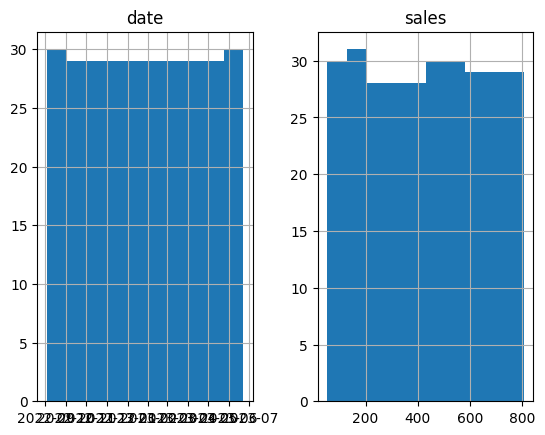

In [13]:
df_train.hist()
plt.show()

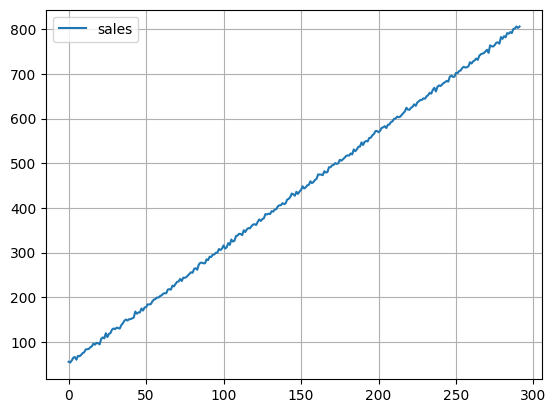

In [14]:
sns.lineplot(df_train)
plt.grid(True)
plt.show()

/tmp/ipykernel_3789/738781357.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['date'] = pd.to_datetime(df_train['date'])


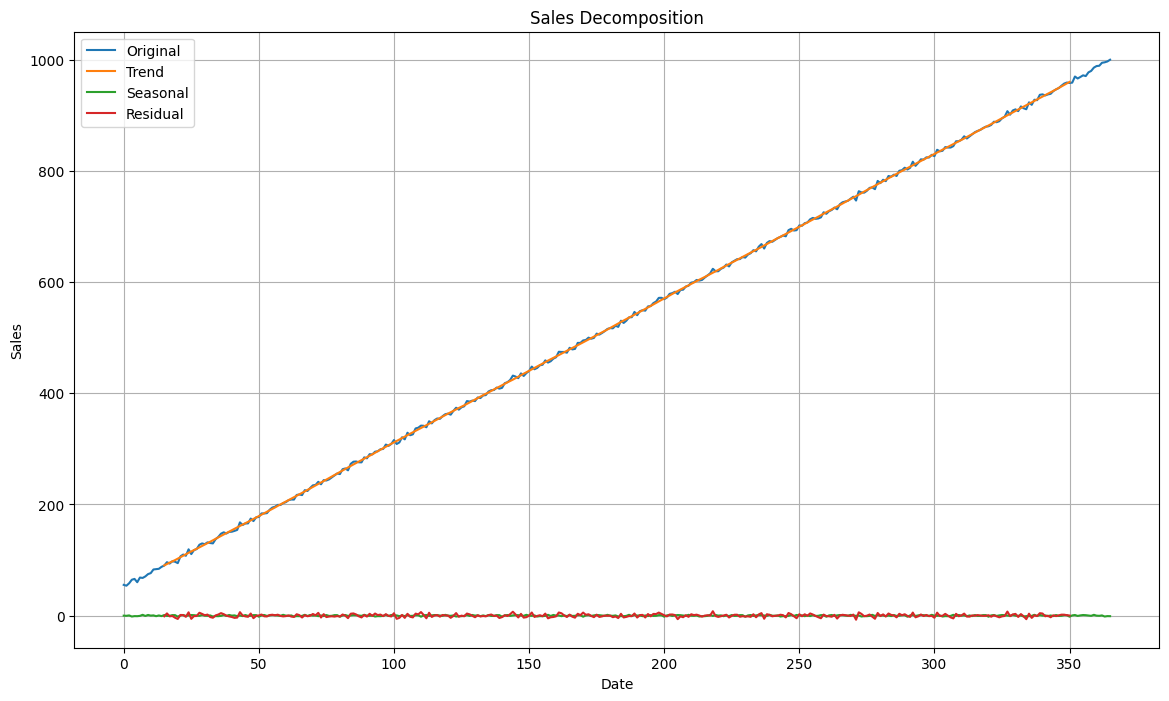

In [18]:
df_train['date'] = pd.to_datetime(df_train['date'])
df_train.set_index('date', inplace=True)


decomposition = seasonal_decompose(df_raw['sales'], period=30)  # or 7 for weekly, etc.
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot all components
plt.figure(figsize=(14, 8))
sns.lineplot(data=df_raw['sales'], label='Original')
sns.lineplot(data=trend, label='Trend')
sns.lineplot(data=seasonal, label='Seasonal')
sns.lineplot(data=residual, label='Residual')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Decomposition')
plt.legend()
plt.grid(True)
plt.show()




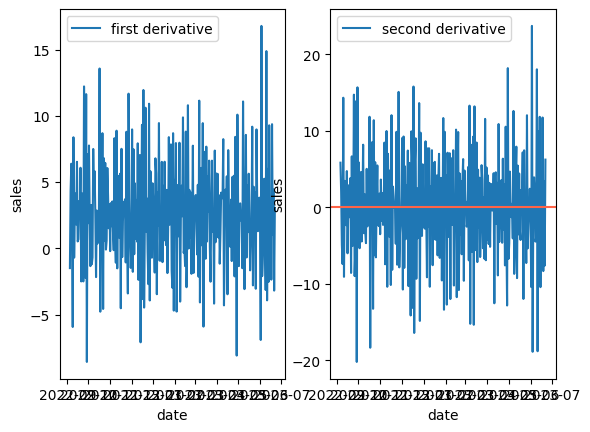

In [20]:
# d = stationarity, data points have no trend
fig,ax=plt.subplots(1,2)
sns.lineplot(df_train['sales'].diff(),label='first derivative',ax=ax[0])
sns.lineplot(df_train['sales'].diff().diff(),label='second derivative',ax=ax[1])
plt.axhline(0,color='tomato')
plt.show()

In [21]:
# alpha = 0.05 if the p value is above alpha then we can say that it is not stationary (it has trend)
# if p value < alpha then we can rule out that it is stationary  (it has no trend)
ad_fuller = adfuller(df_train)
print(f'adf statistic: {ad_fuller[0]:.2f}')
print(f'adf P Value: {ad_fuller[1]:.2f}')

adf statistic: 0.47
adf P Value: 0.98


In [23]:
ad_fuller = adfuller(df_train['sales'].diff().dropna())
print(f'adf statistic: {ad_fuller[0]:.2f}')
print(f'adf P Value: {ad_fuller[1]:.2f}')

adf statistic: -12.68
adf P Value: 0.00


In [24]:
ad_fuller = adfuller(df_train['sales'].diff().diff().dropna())
print(f'adf statistic: {ad_fuller[0]:.2f}')
print(f'adf P Value: {ad_fuller[1]:.2f}')

adf statistic: -10.32
adf P Value: 0.00


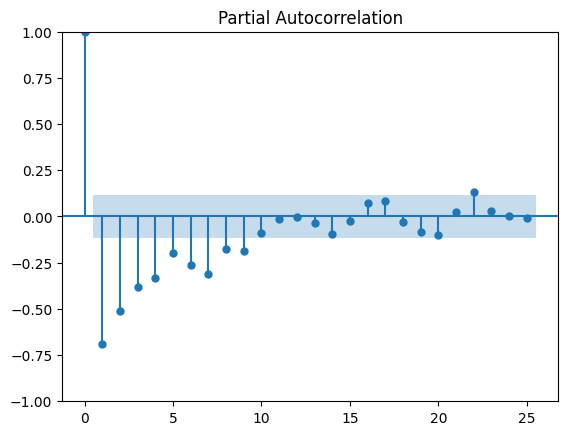

In [26]:
# value p is the autoregressive term - autoregressive = seasonality
plot_pacf(df_train.diff().diff().dropna())
plt.show()

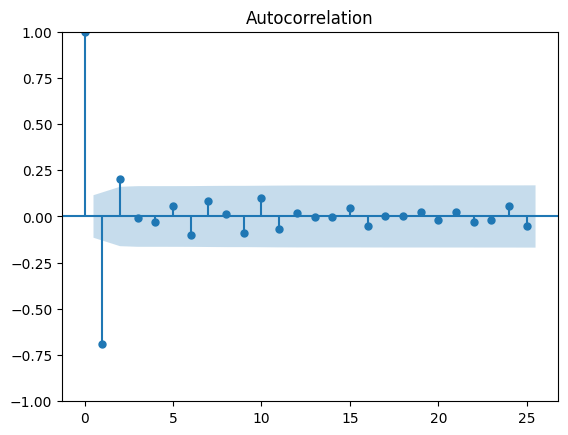

In [27]:
# q is the moving average
plot_acf(df_train.diff().diff().dropna())
plt.show()

In [28]:
arima = ARIMA(df['sales'],order=(2,1,2)) # order variables above 'd' (differencing),'p' (partial autocorrelation), 'q' (moving average) the goal in setting these is to make the P>|z| to be the lowest possible. find the lowest AIC or P>|z| for highest precision
ts_arima = arima.fit()
print(ts_arima.summary())

/workspaces/time_series_homework/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/time_series_homework/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                  366
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -922.450
Date:                Sun, 04 May 2025   AIC                           1854.900
Time:                        23:51:29   BIC                           1874.400
Sample:                             0   HQIC                          1862.649
                                - 366                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9074      0.011     85.349      0.000       0.887       0.928
ar.L2          0.0926      0.011      8.715      0.000       0.072       0.113
ma.L1         -1.9093      0.025    -75.556      0.0

/workspaces/time_series_homework/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


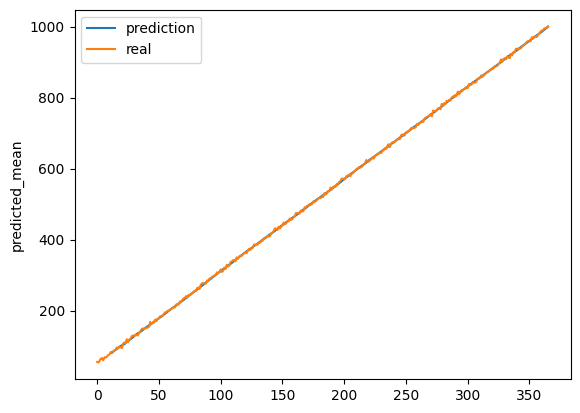

In [30]:
y_hat = ts_arima.predict(12) # argument 1, how many points into the future do you want to predict?
sns.lineplot(y_hat, label='prediction')
sns.lineplot(df['sales'],label='real')
plt.show()